In [3]:
import scipy.io
import numpy
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from multiprocessing import Pool
from scipy import stats
from scipy.optimize import curve_fit

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# Lineplots first!
## Odd is Accuracy Even is Speed

## 0 1 are sudden

In [2]:
def lineplots(data, block, first, last):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))

    for i in range(first,last):
        plt.plot(traj['x'][0][i][0], traj['y'][0][i][0])


In [3]:
interact(lineplots, data = widgets.ToggleButtons(options = range(1000, 1060)), block = widgets.IntSlider(max = 11, min = 0, value = 0, step = 1),
        first = widgets.IntSlider(max = 63, min = 0, value = 0, step = 1), last = widgets.IntSlider(max = 64, min = 1, value = 1, step = 1))

interactive(children=(ToggleButtons(description='data', options=(1000, 1001, 1002, 1003, 1004, 1005, 1006, 100…

<function __main__.lineplots(data, block, first, last)>

## Error Vs Time plots

Divide Trajectories by 5. Calculate mean and standard deviation of difference between ideal and actual trajectories (both divided by 5) for all 64 trajectories in a block. 
From the movement time, calculate how long it took to finish each of these 5 trajectories. Calculate mean and standard deviation across 64 trials. 

This might as well just be equal to the mean and standard deviation of the **number** of points in each of those five quantiles for all trajectories.



# Error Calculation
Takes in a trajectory loaded from the mat file and calculates error by comparing minimum distance from x and y coordinates of the actual trajectory to the ideal trajectory

In [3]:
#square_coord = scipy.io.loadmat('data/pilot/pilot_1/squares/coordinates/squares3.mat')
#traj = scipy.io.loadmat('data/pilot/pilot_1/actual_trajectories/trajectories3.mat')
#def calc_error(traj, square_coord):
# The version above uses square coordinates
def calc_error(traj):    
    error = list()
    for j in range(64):
        traj_dist = list()
        trajx, trajy = traj['x'][0][j][0], traj['y'][0][j][0]
        #end_pointx, end_pointy  = square_coord['squareX'][0][j], square_coord['squareY'][0][j]
        end_pointx, end_pointy  = traj['x'][0][j][0][-1], traj['y'][0][j][0][-1]

        xline = numpy.linspace(0, end_pointx, 500)
        yline = numpy.linspace(0, end_pointy, 500)

        for i in range(len(trajx)):
            xdist = min(numpy.absolute(xline-trajx[i]))
            ydist = min(numpy.absolute(yline-trajy[i]))
            dist = numpy.sqrt(xdist**2 + ydist**2)
            traj_dist.append(dist)
        error.append(traj_dist)
    return error
#dist = numpy.linalg.norm(numpy.cross(p2-p1, p1-p3))/numpy.linalg.norm(p2-p1)

In [4]:
#traj['x'][0][0][0][-1]

In [5]:
#calc_error(traj, square_coord)

Participant 1 Gradual Change Accuracy emphasis

Participant 2 Sudden change Accuracy emphasis

Participant 3 Gradual change Speed emphasis

# Time quintiles:
X axis is cummulative sum of the number of samples in the trajectory, averaged across all trajectories. 
Y axis is the mean of error in that time quantile, averaged across all trajectories


In [6]:
def errorvstime(data, block, num_trajectories):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    ideal_traj = scipy.io.loadmat('data/data{data}/ideal_trajectories/trajectories{block}.mat'.format(block = str(block), data=str(data)))
    #squares = scipy.io.loadmat('data/participants/data{data}/squares/coordinates/squares{block}.mat'.format(block=str(block), data=str(data)))
    #xdiff = (ideal_traj['idealXs'] - traj['x'])
    #ydiff = (ideal_traj['idealYs'] - traj['y'])
    error = calc_error(traj)[:num_trajectories]
    #error = xdiff**2+ydiff**2
    #print (error)
    error_means = numpy.zeros((num_trajectories, 5))
    for i in range(num_trajectories):
        n = len(error[i])
        for j in range(5):
            error_means[i, j] = numpy.mean(error[i][int(numpy.floor((j)*n/5)):int(numpy.floor((j+1)*n/5))])
#            error_means[i, j] = numpy.median(error[i][int(numpy.floor((j)*n/5)):int(numpy.floor((j+1)*n/5))])
         #error_means[i, ] = error_means[i, ]/max(error_means[i,])

    
    time_means = numpy.zeros((num_trajectories, 5))

    for i in range(num_trajectories):
        n = len(error[i])
        for j in range(5):
            time_means[i, j] = len(error[i][int(numpy.floor((j)*n/5)):int(numpy.floor((j+1)*n/5))])
    times = numpy.cumsum(numpy.mean(time_means, axis = 0))
    plt.errorbar(times, numpy.mean(error_means, axis = 0), xerr = stat.sem(time_means, axis = 0), yerr = stat.sem(error_means, axis = 0))
    plt.ylabel('Error')
    plt.xlabel('Time')
    plt.xlim(0, 100)
    plt.ylim(-20, 70)
    return times, numpy.mean(error_means, axis = 0)

Calculate error vs time for each block collapsed across participants.

C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


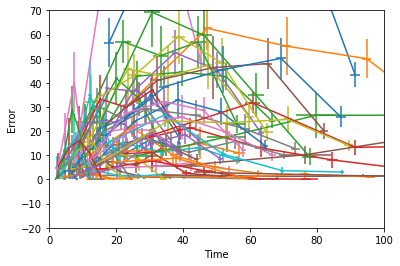

In [7]:
times = numpy.zeros((60, 5))
errors = numpy.zeros((60, 5))
for i in range(1000, 1059):
    temp = errorvstime(i, 11, 32)
    times[i-1000] = temp[0]
    errors[i-1000] = temp[1] 
    #print (i)

In [ ]:
times_speed_sudden = numpy.zeros((60, 5))
times_speed_gradual = numpy.zeros((60, 5))
times_accuracy_sudden = numpy.zeros((60, 5))
times_accuracy_gradual = numpy.zeros((60, 5))
errors_speed_sudden = numpy.zeros((60, 5))
errors_speed_gradual = numpy.zeros((60, 5))
errors_accuracy_sudden = numpy.zeros((60, 5))
errors_accuracy_gradual = numpy.zeros((60, 5))
for i in range(len(times)):
    if i%4 == 0:
        times_speed_sudden[i] = times[i]
        errors_speed_sudden[i] = errors[i]
    elif i%4 == 1:
        times_accuracy_sudden[i] = times[i]
        errors_accuracy_sudden[i] = errors[i]
    elif i%4 == 2:
        times_speed_gradual[i] = times[i]
        errors_speed_gradual[i] = errors[i]
    elif i%4 == 3:
        times_accuracy_gradual[i] = times[i]
        errors_accuracy_gradual[i] = errors[i]
       

In [ ]:
times_speed_gradual = numpy.reshape(times_speed_gradual[numpy.nonzero(times_speed_gradual)], (int(len(times_speed_gradual[numpy.nonzero(times_speed_gradual)])/5), 5))
errors_speed_gradual = numpy.reshape(errors_speed_gradual[numpy.nonzero(errors_speed_gradual)], (int(len(errors_speed_gradual[numpy.nonzero(errors_speed_gradual)])/5), 5))
times_speed_sudden = numpy.reshape(times_speed_sudden[numpy.nonzero(times_speed_sudden)], (int(len(times_speed_sudden[numpy.nonzero(times_speed_sudden)])/5), 5))
errors_speed_sudden = numpy.reshape(errors_speed_sudden[numpy.nonzero(errors_speed_sudden)], (int(len(errors_speed_sudden[numpy.nonzero(errors_speed_sudden)])/5), 5))
times_accuracy_gradual = numpy.reshape(times_accuracy_gradual[numpy.nonzero(times_accuracy_gradual)], (int(len(times_accuracy_gradual[numpy.nonzero(times_accuracy_gradual)])/5), 5))
errors_accuracy_gradual = numpy.reshape(errors_accuracy_gradual[numpy.nonzero(errors_accuracy_gradual)], (int(len(errors_accuracy_gradual[numpy.nonzero(errors_accuracy_gradual)])/5), 5))
times_accuracy_sudden = numpy.reshape(times_accuracy_sudden[numpy.nonzero(times_accuracy_sudden)], (int(len(times_accuracy_sudden[numpy.nonzero(times_accuracy_sudden)])/5), 5))
errors_accuracy_sudden = numpy.reshape(errors_accuracy_sudden[numpy.nonzero(errors_accuracy_sudden)], (int(len(errors_accuracy_sudden[numpy.nonzero(errors_accuracy_sudden)])/5), 5))


In [ ]:
times_speed_sudden

In [ ]:
#numpy.mean(times_accuracy_gradual, axis = 0)
#numpy.nanmean(errors_speed_sudden, axis = 0)
#stat.sem(times_accuracy_gradual, axis = 0)
#numpy.nanstd(errors_accuracy_gradual, axis = 0)/numpy.sqrt(errors_accuracy_gradual)
#numpy.nanstd(errors_accuracy_gradual)

numpy.shape(numpy.nonzero(times_accuracy_sudden))

In [ ]:
fig,(ax1)=plt.subplots(1,1)
ax1.errorbar(numpy.nanmean(times_speed_gradual, axis = 0), numpy.nanmean(errors_speed_gradual, axis = 0), xerr=stat.sem(times_speed_gradual, axis = 0), yerr=numpy.nanstd(errors_speed_gradual, axis = 0)/numpy.sqrt(len(errors_speed_gradual)), label = "speed_gradual")
ax1.errorbar(numpy.nanmean(times_speed_sudden, axis = 0), numpy.nanmean(errors_speed_sudden, axis = 0), xerr=stat.sem(times_speed_sudden, axis = 0), yerr=numpy.nanstd(errors_speed_sudden, axis = 0)/numpy.sqrt(len(errors_speed_sudden)), label = "speed_sudden")
ax1.errorbar(numpy.nanmean(times_accuracy_gradual, axis = 0), numpy.nanmean(errors_accuracy_gradual, axis = 0), xerr=stat.sem(times_accuracy_gradual, axis = 0), yerr=numpy.nanstd(errors_accuracy_gradual, axis = 0)/numpy.sqrt(len(errors_accuracy_gradual)), label = "accuracy_gradual")
ax1.errorbar(numpy.nanmean(times_accuracy_sudden, axis = 0), numpy.nanmean(errors_accuracy_sudden, axis = 0), xerr=stat.sem(times_accuracy_sudden, axis = 0), yerr=numpy.nanstd(errors_accuracy_sudden, axis = 0)/numpy.sqrt(len(errors_accuracy_sudden)), label = "accuracy_sudden")
ax1.legend()
plt.xlabel('Mean time point in quintile')
plt.ylabel('Error')


# Time Bar plots

In [ ]:
pos = [0, 1, 2, 3]
handles = plt.bar(pos, [numpy.median(times_speed_gradual), numpy.median(times_accuracy_gradual), numpy.median(times_speed_sudden), numpy.median(times_accuracy_sudden)], yerr = [numpy.mean(stat.sem(times_speed_gradual)), numpy.mean(stat.sem(times_accuracy_gradual)), numpy.mean(stat.sem(times_speed_sudden)), numpy.mean(stat.sem(times_accuracy_sudden))], color = ['Blue', 'Green', 'Blue', 'Green'], capsize = 3)
plt.xticks([0.5, 2.5], ['Gradual', 'Sudden'])
plt.ylabel('Times')
plt.xlabel('Condition')

plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
#handles[0]

In [ ]:
numpy.ravel(times_accuracy_gradual)

In [ ]:
pos = [1, 2]
yerr = [numpy.mean(stat.sem(numpy.concatenate((times_speed_gradual, times_accuracy_gradual)))), numpy.mean(stat.sem(numpy.concatenate((times_speed_sudden, times_accuracy_sudden))))]
plt.bar(pos, [numpy.mean(numpy.concatenate((times_speed_gradual, times_accuracy_gradual))), numpy.mean(numpy.concatenate((times_speed_sudden, times_accuracy_sudden)))], yerr = yerr, color = 'blue')
plt.xticks(pos, ['Gradual', 'Sudden'])
plt.ylabel('Times')
plt.xlabel('Condition')


In [ ]:
pos = [0, 1]
yerr = [numpy.mean(stat.sem(numpy.concatenate((times_speed_gradual, times_speed_sudden)))), numpy.mean(stat.sem(numpy.concatenate((times_accuracy_gradual, times_accuracy_sudden))))]
plt.bar(pos, [numpy.mean(numpy.concatenate((times_speed_gradual, times_speed_sudden))), numpy.mean(numpy.concatenate((times_accuracy_gradual, times_accuracy_sudden)))], yerr = yerr)
plt.xticks(pos, ['Speed', 'Accuracy'])
plt.ylabel('Times')
plt.xlabel('Condition')


# Error Bar plots

In [ ]:
errors_accuracy_gradual

In [ ]:
#path = 'C:/Users/Tejas/OneDrive/Research/Conferences and Papers/Psychonomics 2019/errors/'
#plt.rcParams[('figure.figsize')] = [8, 6]
pos = [0, 1, 2, 3]
y = [numpy.nanmean(errors_accuracy_sudden),
    numpy.nanmean(errors_speed_sudden),
    numpy.nanmean(errors_accuracy_gradual),
     numpy.nanmean(errors_speed_gradual)
    ]
y_sem = [numpy.mean(stat.sem(times_accuracy_sudden)),
        numpy.mean(stat.sem(times_speed_sudden)),
        numpy.mean(stat.sem(times_accuracy_gradual)),
        numpy.mean(stat.sem(times_speed_gradual))]
#handles = plt.bar(pos, yerr = [numpy.mean(stat.sem(times_speed_gradual)), numpy.nanmean(stat.sem(errors_accuracy_gradual)), numpy.nanmean(stat.sem(times_speed_sudden)), numpy.mean(stat.sem(times_accuracy_sudden))], color = ['Blue', 'Green', 'Blue', 'Green'])
plt.bar(0, y[0], yerr = y_sem[0], capsize = 3, color = 'Blue', alpha = 1)
plt.bar(2, y[1], yerr = y_sem[1], capsize = 3, color = 'Blue', alpha = 0.5)
plt.bar(1, y[2], yerr = y_sem[2], capsize = 3, color = 'Green', alpha = 1)
plt.bar(3, y[3], yerr = y_sem[3], capsize = 3, color = 'Green', alpha = 0.5)

plt.xticks([0, 2, 1, 3], ['Sudden \n Accuracy', 'Sudden \n Speed', 'Gradual \n Accuracy', 'Gradual \nSpeed'], rotation = 'vertical')
plt.ylabel('RMSE')
plt.xlabel('Condition')
#plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
plt.title('Error')
#plt.tight_layout()
#plt.savefig(path+'transfer.png', dpi = 300)


In [ ]:
yerr = [numpy.nanmean(stat.sem(numpy.concatenate((errors_speed_gradual, errors_speed_sudden)))), numpy.nanmean(stat.sem(numpy.concatenate((errors_accuracy_gradual, errors_accuracy_sudden))))]
plt.bar(['Speed', 'Accuracy'], [numpy.nanmean(numpy.concatenate((errors_speed_gradual, errors_speed_sudden))), numpy.nanmean(numpy.concatenate((errors_accuracy_gradual, errors_accuracy_sudden)))], yerr = yerr)
plt.xlabel('Emphasis')
plt.ylabel('Error')
print (yerr)

In [ ]:
yerr = [numpy.nanmean(stat.sem(numpy.concatenate((errors_speed_gradual, errors_accuracy_gradual)))), numpy.nanmean(stat.sem(numpy.concatenate((errors_speed_sudden, errors_accuracy_sudden))))]
plt.bar(['Gradual', 'Sudden'], [numpy.nanmean(numpy.concatenate((errors_speed_gradual, errors_accuracy_gradual))), numpy.nanmean(numpy.concatenate((errors_speed_sudden, errors_accuracy_sudden)))], yerr = yerr)
plt.xlabel('Condition')
plt.ylabel('Error')
print (yerr)

In [ ]:
interact(errorvstime, data = widgets.ToggleButtons(options = range(1,27)), 
                      block = widgets.IntSlider(max = 11, min = 0, value = 0, step = 1))

In [ ]:
aesthetics = numpy.zeros((4, 3, 15))

In [ ]:
aesthetics[0, 0, :] = numpy.array([9, 4, 2, 10, 9, 8, 7, 5, 7, 9, 10, 8, 9, 2, 6])
aesthetics[0, 1, :] = numpy.array([10, 2, 1, 5, 5, 2, 4, 1, 3, 1, 9, 6, 2, 1, 4])
aesthetics[0, 2, :] = numpy.array([10, 7, 1, 4 ,9, 4, 3, 2, 6, 1, 1, 2, 1, 1, 7])
aesthetics[1, 0, :] = numpy.array([10, 4, 10, 10, 3, 8, 7, 10, 6, 2, 2, 10, 5, 1, 1])
aesthetics[1, 1, :] = numpy.array([2, 2, 1, 3, 1, 3, 2, 4, 2, 1, 1, 5, 1, 1, 1])
aesthetics[1, 2, :] = numpy.array([7, 1, 1, 8, 1, 2, 3, 2, 4, 2, 1, 5, 2, 1, 1])
aesthetics[2, 0, :] = numpy.array([1, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2, 1, 1, 1, 2])
aesthetics[2, 1, :] = numpy.array([3, 2, 4, 4, 3, 2, 3, 5, 4, 4, 6, 3, 2, 3, 2])
aesthetics[2, 2, :] = numpy.array([7, 3, 6, 7, 8, 5, 3, 4, 5, 9, 1, 4, 7, 4, 5])
aesthetics[3, 0, :] = numpy.array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1])
aesthetics[3, 1, :] = numpy.array([3, 1, 2, 1, 4, 3, 2, 2, 2, 1, 2, 2, 1, 2, 1 ])
aesthetics[3, 2, :] = numpy.array([3, 4, 2, 2, 4, 2, 5, 4, 1, 5, 2, 6, 4, 2, 2])

In [ ]:
plt.bar(range(1, 11), numpy.bincount(aesthetics[0, 0, :]))

In [ ]:
from collections import Counter

In [ ]:
recounted = Counter(aesthetics[0, 0, :])

In [ ]:
numpy.histogram(aesthetics)

In [ ]:
for i in range(4):
    for j in range(3):
        plt.hist(aesthetics[i, j, :])

Boundary is how good my plan is. Boundary affected by speed/accuracy.

Drift rate affected by gradual vs sudden.

In [ ]:
def errors(data, block):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    ideal_traj = scipy.io.loadmat('data/data{data}/ideal_trajectories/trajectories{block}.mat'.format(block = str(block), data=str(data)))
    #print (traj)
    #squares = scipy.io.loadmat('data/participants/data{data}/squares/coordinates/squares{block}.mat'.format(block=str(block), data=str(data)))
    #xdiff = (ideal_traj['idealXs'] - traj['x'])
    #ydiff = (ideal_traj['idealYs'] - traj['y'])
    error = calc_error(traj)
    return numpy.array(error)

In [ ]:
temp = errors(1000, 1)

In [ ]:
plt.hist(temp[0][])

In [ ]:
def all_errors(num_participants, num_blocks, num_trajectories):
    error_sum = numpy.zeros((num_participants, num_blocks, num_trajectories))
    error_std = numpy.zeros((num_participants, num_blocks, num_trajectories))
    for participant in range(num_participants):
        for block in range(num_blocks):
            temp = errors(participant+1000, block)
            for trial in range(num_trajectories):
                error_sum[participant, block, trial] = numpy.nanmean(temp[trial])
                error_std[participant, block, trial] = stat.sem(temp[trial])
        print (participant)
            #error_sum1.append(numpy.mean(numpy.sum(errors(1, block), axis=0)))
            #error_std1.append(numpy.std(numpy.sum(errors(1, block), axis=0)))
            #error_sum2.append(numpy.mean(numpy.sum(errors(2, block), axis=0)))
            #error_std2.append(numpy.std(numpy.sum(errors(2, block), axis=0)))
            #error_sum3.append(numpy.mean(numpy.sum(errors(3, block), axis=0)))
            #error_std3.append(numpy.std(numpy.sum(errors(3, block), axis=0)))    
    return error_sum, error_std

In [ ]:
error_sum, error_std = all_errors(60, 12, 64)

In [ ]:
plt.plot(numpy.mean((error_sum[1:-1:2]), axis = 0), 'k-')
plt.plot(numpy.mean((error_sum[2:-1:2]), axis = 0), 'k-')

plot1 = plt.fill_between(range(12), numpy.mean(error_sum[1:-1:2], axis = 0) + stat.sem(error_sum[1:-1:2]), numpy.mean(error_sum[1:-1:2], axis = 0) - stat.sem(error_sum[1:-1:2]), alpha = 0.5)
plot2 = plt.fill_between(range(12), numpy.mean(error_sum[2:-1:2], axis = 0) + stat.sem(error_sum[2:-1:2]), numpy.mean(error_sum[2:-1:2], axis = 0) - stat.sem(error_sum[2:-1:2]), alpha = 0.5)
plt.legend((plot1, plot2), ("Accuracy", "Speed"))
#error_sum[3]
#error_sum1
plt.xlabel('Block')
plt.ylabel('Error')

In [ ]:
def plot_error_means(errors, path):
    #plt.rcParams[('figure.figsize')] = [8, 6]

    mean_errors = numpy.mean(error_sum, axis =2)
    plt.errorbar(range(1, 11), numpy.mean(numpy.mean(error_sum, axis = 2)[3::4], axis = 0)[1:-1], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[1:-1], capsize=3, color = [0, 0, 0])
    #plt.errorbar(0, numpy.mean(numpy.mean(error_sum, axis = 2)[3::4], axis = 0)[0], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[3::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.mean(error_sum, axis = 2)[3::4], axis = 0)[11], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[3::4], axis = 0)[11], capsize=3, fmt = 'd', fillstyle = 'none', markersize = 10, color = [0.5, 0.5, 0.5])
    #plt.text(x=5, y = 80, s = '14 Participants')
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.title('Gradual Accuracy')
    plt.xticks(range(12), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])

    #y_lim_max = numpy.max((mean_errors)) + 5
    y_lim_max = 100
    plt.ylim((0, y_lim_max))
#    print(max(np.mean(quantiles[3::4][:, :, 3], axis = 0)[1:-1]) + 0.7)
    #plt.tight_layout()
    #plt.savefig(path+'learning_GA.png', dpi = 600)
    plt.show()

    plt.errorbar(range(1, 11), numpy.mean(numpy.mean(error_sum, axis = 2)[2::4], axis = 0)[1:-1], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[2::4], axis = 0)[1:-1], capsize=3, color = [0, 0, 0])
    #plt.errorbar(0, numpy.mean(numpy.mean(error_sum, axis = 2)[2::4], axis = 0)[0], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[2::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.mean(error_sum, axis = 2)[2::4], axis = 0)[11], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[2::4], axis = 0)[11], capsize=3, fmt = 'd', fillstyle = 'full', markersize = 10, color = [0.5, 0.5, 0.5])
    #plt.text(x=5, y = 80, s = '15 Participants')
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.xticks(range(12), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.title('Gradual Speed')
    plt.ylim(2, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_GS.png', dpi = 600)
    plt.show()
    #y_lim_max = 2200

    plt.errorbar(range(1, 11), numpy.mean(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[1:-1], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[1:-1], capsize=3, color = [0, 0, 0])
    #plt.errorbar(0, numpy.mean(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[0], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[11], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[11], capsize=3, fmt = 's', fillstyle = 'none', markersize = 10, color = [0.5, 0.5, 0.5])
    #plt.text(x=5, y = 80, s = '15 Participants')
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.xticks(range(12), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.title('Sudden Accuracy')
    #y_lim_max = 10000

    plt.ylim(2, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_SA.png', dpi = 600)
    plt.show()

    plt.errorbar(range(1, 11), numpy.mean(numpy.mean(error_sum, axis = 2)[4::4], axis = 0)[1:-1], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[4::4], axis = 0)[1:-1], capsize=3, color = [0, 0, 0])
    #plt.errorbar(0, numpy.mean(numpy.mean(error_sum, axis = 2)[4::4], axis = 0)[0], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[4::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.mean(error_sum, axis = 2)[4::4], axis = 0)[11], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[4::4], axis = 0)[11], capsize=3, fmt = 's', fillstyle = 'full', markersize = 10, color = [0.5, 0.5, 0.5])
    #plt.text(x=5, y = 80, s = '14 Participants')
    plt.xticks(range(12), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.title('Sudden Speed')
#    y_lim_max = 2600
    plt.ylim(2, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_SS.png', dpi = 600)
    plt.show()


In [ ]:
plot_error_means(error_sum, "C:/Users/Tejas/OneDrive/Research/Conferences and Papers/Psychonomics 2019/errors/")

In [ ]:
#numpy.mean(numpy.mean(error_sum[1::4], axis = 2), axis = 0)
#stat.sem(numpy.mean(error_sum[1::4], axis = 2), axis = 0)
def plot_error_means_transfer(errors, text):
#    quantiles = get_quantile(total_times)
    xpos = [0, 1, 2, 3, 4]
    y = numpy.array([numpy.mean(numpy.median(error_sum[1::4], axis = 2), axis = 0)[11],
                  numpy.mean(numpy.mean(error_sum[0::4], axis = 2), axis = 0)[11],
                  numpy.mean(numpy.mean(error_sum[3::4], axis = 2), axis = 0)[11],
                  numpy.mean(numpy.mean(error_sum[2::4], axis = 2), axis = 0)[11]] 
                  )
    y_sem = numpy.array([stat.sem(numpy.mean(error_sum[1::4], axis = 2), axis = 0)[11], 
                    stat.sem(numpy.mean(error_sum[0::4], axis = 2), axis = 0)[11],
                    stat.sem(numpy.mean(error_sum[3::4], axis = 2), axis = 0)[11],
                    stat.sem(numpy.mean(error_sum[2::4], axis = 2), axis = 0)[11]])
    #print (y_sem[0])
    plt.bar(0, y[0], yerr = y_sem[0], capsize = 3, fill = False)
    plt.bar(1, y[1], yerr = y_sem[1], capsize = 3, color = [0.5, 0.5, 0.5])
    plt.bar(2, y[2], yerr = y_sem[2], capsize = 3, hatch = '\\', fill = False)
    plt.bar(3, y[3], yerr = y_sem[3], capsize = 3, color = [0.5, 0.5, 0.5], hatch = '\\')

#    handles = plt.bar(range(4), y, yerr = y_sem, capsize = 3, color = ['Blue', 'Green', 'Blue', 'Green'], alpha = [1, 0.5, 0.5, 1])
    plt.xticks([0, 1, 2, 3], ['Sudden \n Accuracy', 'Sudden \n Speed', 'Gradual \n Accuracy', 'Gradual \nSpeed'], rotation = 'vertical')
    plt.ylabel('Error (RMSE)')
    plt.xlabel('Condition')
    #plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
    plt.ylim((0, 45))
    plt.title(text)
    

#numpy.shape(numpy.mean(error_sum[1::4], axis = 0))

In [ ]:
plot_error_means_transfer(error_sum, 'Errors')

In [ ]:
data = 10
block = 10
num_trials = 2
traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data+1000)))
for trial in range(num_trials):
    trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
    diffx, diffy = trajx[1:] - trajx[:-1], trajy[1:] - trajy[:-1]
    #print (diffx, diffy)

In [ ]:
plt.scatter(trajx, trajy)
numpy.sum(numpy.sqrt((numpy.square(diffx, dtype = float) + numpy.square(diffy, dtype = float))))

In [ ]:
#Calculate the actual distance travelled in a trajectory.
def calc_dist_travelled(num_data, num_block, num_trials):
    dist = numpy.zeros((num_data, num_block, num_trials))
    for data in range(num_data):
        for block in range(num_block):
            traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data+1000)))
            for trial in range(num_trials):
                trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
                diffx, diffy = trajx[1:] - trajx[:-1], trajy[1:] - trajy[:-1]
                #print (diffx, diffy)
                dist[data][block][trial] = numpy.sum(numpy.sqrt((numpy.square(diffx, dtype = float) + numpy.square(diffy, dtype = float))))
    return dist

In [ ]:
dist = calc_dist_travelled(60, 12, 32)

In [ ]:
def plot_dist_means(distances, path):
    #plt.rcParams[('figure.figsize')] = [8, 6]

    mean_errors = numpy.mean(distances, axis =2)
    plt.errorbar(range(1, 11), numpy.mean(numpy.nanmedian(distances, axis = 2)[3::4], axis = 0)[1:-1], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[3::4], axis = 0)[1:-1], capsize=3)
    #plt.errorbar(0, numpy.mean(numpy.median(distances, axis = 2)[3::4], axis = 0)[0], yerr = stat.sem(numpy.median(distances, axis = 2)[3::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.nanmedian(distances, axis = 2)[3::4], axis = 0)[11], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[3::4], axis = 0)[11], capsize=3, fmt = 's')
    #plt.text(x=5, y = 80, s = '14 Participants')
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.title('Gradual Accuracy')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])

    #y_lim_max = numpy.max((mean_errors)) + 5
    #y_lim_max = 500000
    #plt.ylim((0, y_lim_max))
#    print(max(np.mean(quantiles[3::4][:, :, 3], axis = 0)[1:-1]) + 0.7)
    #plt.tight_layout()
    #plt.savefig(path+'learning_GA.png', dpi = 600)
    plt.show()

    plt.errorbar(range(1, 11), numpy.mean(numpy.nanmedian(distances, axis = 2)[2::4], axis = 0)[1:-1], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[2::4], axis = 0)[1:-1], capsize=3)
    #plt.errorbar(0, numpy.mean(numpy.median(distances, axis = 2)[2::4], axis = 0)[0], yerr = stat.sem(numpy.median(distances, axis = 2)[2::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.nanmedian(distances, axis = 2)[2::4], axis = 0)[11], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[2::4], axis = 0)[11], capsize=3, fmt = 's')
    #plt.text(x=5, y = 80, s = '15 Participants')
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.title('Gradual Speed')
    #plt.ylim(-1, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_GS.png', dpi = 600)
    plt.show()
    #y_lim_max = 2200

    plt.errorbar(range(1, 11), numpy.mean(numpy.nanmedian(distances, axis = 2)[1::4], axis = 0)[1:-1], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[1::4], axis = 0)[1:-1], capsize=3)
    #plt.errorbar(0, numpy.mean(numpy.mean(distances, axis = 2)[1::4], axis = 0)[0], yerr = stat.sem(numpy.mean(distances, axis = 2)[1::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.nanmedian(distances, axis = 2)[1::4], axis = 0)[11], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[1::4], axis = 0)[11], capsize=3, fmt = 's')
    #plt.text(x=5, y = 80, s = '15 Participants')
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.title('Sudden Accuracy')
    #y_lim_max = 10000

    #plt.ylim(2, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_SA.png', dpi = 600)
    plt.show()

    plt.errorbar(range(1, 11), numpy.mean(numpy.nanmedian(distances, axis = 2)[4::4], axis = 0)[1:-1], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[4::4], axis = 0)[1:-1], capsize=3)
    #plt.errorbar(0, numpy.mean(numpy.median(distances, axis = 2)[4::4], axis = 0)[0], yerr = stat.sem(numpy.median(distances, axis = 2)[4::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.nanmedian(distances, axis = 2)[4::4], axis = 0)[11], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[4::4], axis = 0)[11], capsize=3, fmt = 's')
    #plt.text(x=5, y = 80, s = '14 Participants')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.title('Sudden Speed')
#    y_lim_max = 2600
    #plt.ylim(2, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_SS.png', dpi = 600)
    plt.show()


In [ ]:
#plt.plot(numpy.mean(numpy.mean(dist[0::4], axis = 2), axis = 0))
#plt.plot(numpy.mean(numpy.mean(dist[1::4], axis = 2), axis = 0))
#plt.plot(numpy.mean(numpy.mean(dist[2::4], axis = 2), axis = 0))
#plt.plot(numpy.mean(numpy.mean(dist[3::4], axis = 2), axis = 0))
plot_dist_means(dist, '')

In [ ]:
#numpy.mean(numpy.mean(error_sum[1::4], axis = 2), axis = 0)
#stat.sem(numpy.mean(error_sum[1::4], axis = 2), axis = 0)
def plot_dist_means_transfer(distances, text):
#    quantiles = get_quantile(total_times)
    xpos = [0, 1, 2, 3, 4]
    y = numpy.array([numpy.mean(numpy.median(distances[1::4], axis = 2), axis = 0)[11],# - numpy.mean(numpy.median(distances[1::4], axis = 2), axis = 0)[10],
                  numpy.mean(numpy.median(distances[4::4], axis = 2), axis = 0)[11], #- numpy.mean(numpy.median(distances[4::4], axis = 2), axis = 0)[10],
                  numpy.mean(numpy.median(distances[3::4], axis = 2), axis = 0)[11], #- numpy.mean(numpy.median(distances[3::4], axis = 2), axis = 0)[10],
                  numpy.mean(numpy.median(distances[2::4], axis = 2), axis = 0)[11]] #- numpy.mean(numpy.median(distances[2::4], axis = 2), axis = 0)[10]] 
                  )
    y_sem = numpy.array([stat.sem(numpy.median(distances[1::4], axis = 2), axis = 0)[11], 
                    stat.sem(numpy.median(distances[4::4], axis = 2), axis = 0)[11],
                    stat.sem(numpy.median(distances[3::4], axis = 2), axis = 0)[11],
                    stat.sem(numpy.median(distances[2::4], axis = 2), axis = 0)[11]])
    #print (y_sem[0])
    #y_sem = numpy.array([0, 0, 0, 0])
    plt.bar(0, y[0], yerr = y_sem[0], capsize = 3, color = 'Blue', alpha = 1)
    plt.bar(2, y[1], yerr = y_sem[1], capsize = 3, color = 'Blue', alpha = 0.5)
    plt.bar(1, y[2], yerr = y_sem[2], capsize = 3, color = 'Green', alpha = 0.5)
    plt.bar(3, y[3], yerr = y_sem[3], capsize = 3, color = 'Green', alpha = 1)

#    handles = plt.bar(range(4), y, yerr = y_sem, capsize = 3, color = ['Blue', 'Green', 'Blue', 'Green'], alpha = [1, 0.5, 0.5, 1])
    plt.xticks([0, 2, 1, 3], ['Sudden \n Accuracy', 'Sudden \n Speed', 'Gradual \n Accuracy', 'Gradual \nSpeed'], rotation = 'vertical')
    plt.ylabel('Error (RMSE)')
    plt.xlabel('Condition')
    #plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
    plt.title(text)
    
    print (y)
#numpy.shape(numpy.mean(error_sum[1::4], axis = 0))

In [ ]:
plot_dist_means_transfer(dist, 'text')

In [ ]:
numpy.array(diffx, dtype=float)**2

In [ ]:
numpy.shape(dist)

In [ ]:
#ybar = [error_sum[2:-1:4] - error_sum[2:-1:4][10], numpy.mean(error_sum[3:-1:4], axis = 0)[11] - numpy.mean(error_sum[3:-1:4], axis = 0)[10], numpy.mean(error_sum[4:-1:4], axis = 0)[11] - numpy.mean(error_sum[4:-1:4], axis = 0)[10], numpy.mean(error_sum[1:-1:4], axis = 0)[11] - numpy.mean(error_sum[1:-1:4], axis = 0)[10]]
y = [error_sum[2:-1:4][:, 11] - error_sum[2:-1:4][:, 10], error_sum[3:-1:4][:, 11] - error_sum[3:-1:4][:, 10], error_sum[4:-1:4][:, 11] - error_sum[4:-1:4][:, 10], error_sum[1:-1:4][:, 11] - error_sum[1:-1:4][:, 10]]
for i in y[3]:
    print (i)


In [ ]:
plt.plot(numpy.mean((error_sum[1:-1:4]), axis = 0), 'k-')
plt.plot(numpy.mean((error_sum[2:-1:4]), axis = 0), 'k-')
plt.plot(numpy.mean((error_sum[3:-1:4]), axis = 0), 'k-')
plt.plot(numpy.mean((error_sum[4:-1:4]), axis = 0), 'k-')

plot1 = plt.fill_between(range(12), numpy.mean(error_sum[1:-1:2], axis = 0) + stat.sem(error_sum[1:-1:2]), numpy.mean(error_sum[1:-1:2], axis = 0) - stat.sem(error_sum[1:-1:2]), alpha = 0.5)
plot2 = plt.fill_between(range(12), numpy.mean(error_sum[2:-1:2], axis = 0) + stat.sem(error_sum[2:-1:2]), numpy.mean(error_sum[2:-1:2], axis = 0) - stat.sem(error_sum[2:-1:2]), alpha = 0.5)
plot3 = plt.fill_between(range(12), numpy.mean(error_sum[3:-1:2], axis = 0) + stat.sem(error_sum[3:-1:2]), numpy.mean(error_sum[3:-1:2], axis = 0) - stat.sem(error_sum[3:-1:2]), alpha = 0.5)
plot4 = plt.fill_between(range(12), numpy.mean(error_sum[4:-1:2], axis = 0) + stat.sem(error_sum[4:-1:2]), numpy.mean(error_sum[4:-1:2], axis = 0) - stat.sem(error_sum[4:-1:2]), alpha = 0.5)

plt.legend((plot1, plot2, plot3, plot4), ("AS", "SG", "AG", "SS"))
#error_sum[3]
#error_sum1
plt.xlabel('Block')
plt.ylabel('Error')

In [ ]:
all_errors1 = numpy.zeros((10, 64))
all_errors2 = numpy.zeros((10, 64))
for i in range(10):
    errors1 = errors(1, i)
    errors2 = errors(3, i)
    for j in range(64):
        all_errors1[i,j] = numpy.sum(errors1[j])
        all_errors2[i, j] = numpy.sum(errors2[j])
#numpy.sum(errors(1, 1))

In [ ]:
lm.predict(11)


In [ ]:
error_sum[11]

In [ ]:
trial_errors = list()
for i in range(12):
    block_error = errors(1, i)
    for j in range(64):
        trial_errors.append(numpy.mean(block_error[j]))

In [ ]:
plt.plot(trial_errors)

In [ ]:
trial_errors = list()
for i in range(12):
    block_error = errors(2, i)
    for j in range(64):
        trial_errors.append(numpy.mean(block_error[j]))

In [ ]:
ax = plt.axes()
ax.plot(trial_errors)

Error, movement time and initiation time in the same plot.
Across groups
Collapse movements across subjects in the group

In [ ]:
def times(data, block):
    initial_time = scipy.io.loadmat('data/participants/data{data}/initial_time/initial_time{block}.mat'.format(block=str(block), data=str(data)))
    movement_time = scipy.io.loadmat('data/participants/data{data}/movement_time/movement_time{block}.mat'.format(block = str(block), data=str(data)))
    #squares = scipy.io.loadmat('data/participants/data{data}/squares/coordinates/squares{block}.mat'.format(block=str(block), data=str(data)))
    #xdiff = (ideal_traj['idealXs'] - traj['x'])
    #ydiff = (ideal_traj['idealYs'] - traj['y'])
    initial_time = initial_time['initial_time'][:, 0]
    movement_time = movement_time['movement_time'][:, 0]
    return initial_time, movement_time


In [ ]:
initial_times = numpy.zeros((27, 12))
movement_times = numpy.zeros((27, 12))

In [ ]:
for participant in range(1,27):
    if participant == 7:
        continue
    for block in range(12):
        initial_time, movement_time = times(participant, block)
        initial_times[participant, block] = numpy.mean(initial_time['initial_time'])
        movement_times[participant, block] = numpy.mean(movement_time['movement_time'])

In [ ]:
initial_times_mean_sudden = numpy.mean(numpy.row_stack((initial_times[4:-1:4], initial_times[1:-1:4])), axis = 0)
initial_times_sem_sudden = stat.sem(numpy.row_stack((initial_times[4:-1:4], initial_times[1:-1:4])))
plt.plot(initial_times_mean_sudden, 'k-')
plot1 = plt.fill_between(range(12), initial_times_mean_sudden + initial_times_sem_sudden, initial_times_mean_sudden - initial_times_sem_sudden, alpha = 0.5)


initial_times_mean_gradual = numpy.mean(numpy.row_stack((initial_times[2:-1:4], initial_times[3:-1:4])), axis = 0)
initial_times_sem_gradual = stat.sem(numpy.row_stack((initial_times[2:-1:4], initial_times[3:-1:4])))
plt.plot(initial_times_mean_gradual, 'k-')
plot2 = plt.fill_between(range(12), initial_times_mean_gradual + initial_times_sem_gradual, initial_times_mean_gradual - initial_times_sem_gradual, alpha = 0.5)

plt.legend((plot1, plot2), ("Sudden", "Gradual"))
plt.xlabel('Block')
plt.ylabel('Initial Times')

In [ ]:
initial_times_mean_speed = numpy.mean(initial_times[2:-1:2], axis = 0)
initial_times_sem_speed = stat.sem(initial_times[2:-1:2])
plt.plot(initial_times_mean_speed, 'k-')
plot1 = plt.fill_between(range(12), initial_times_mean_speed + initial_times_sem_speed, initial_times_mean_speed - initial_times_sem_speed, alpha = 0.5, color = 'red')


initial_times_mean_accuracy = numpy.mean(initial_times[1:-1:2], axis = 0)
initial_times_sem_accuracy = stat.sem(initial_times[1:-1:2])
plt.plot(initial_times_mean_accuracy, 'k-')
plot2 = plt.fill_between(range(12), initial_times_mean_accuracy + initial_times_sem_accuracy, initial_times_mean_accuracy - initial_times_sem_accuracy, alpha = 0.5, color = 'green')

plt.legend((plot1, plot2), ("Speed", "Accuracy"))
plt.xlabel('Block')
plt.ylabel('Initial Time')

In [ ]:
initial_times_mean_speed_gradual = numpy.mean(initial_times[2:-1:4], axis = 0)
initial_times_sem_speed_gradual = stat.sem(initial_times[2:-1:4])
plt.plot(initial_times_mean_speed_gradual, 'k-')
plot1 = plt.fill_between(range(12), initial_times_mean_speed_gradual + initial_times_sem_speed_gradual, initial_times_mean_speed_gradual - initial_times_sem_speed_gradual, alpha = 0.5)

initial_times_mean_accuracy_gradual = numpy.mean(initial_times[3:-1:4], axis = 0)
initial_times_sem_accuracy_gradual = stat.sem(initial_times[3:-1:4])
plt.plot(initial_times_mean_accuracy_gradual, 'k-')
plot2 = plt.fill_between(range(12), initial_times_mean_accuracy_gradual + initial_times_sem_accuracy_gradual, initial_times_mean_accuracy_gradual - initial_times_sem_accuracy_gradual, alpha = 0.5)

initial_times_mean_speed_sudden = numpy.mean(initial_times[4:-1:4], axis = 0)
initial_times_sem_speed_sudden = stat.sem(initial_times[4:-1:4])
plt.plot(initial_times_mean_speed_sudden, 'k-')
plot3 = plt.fill_between(range(12), initial_times_mean_speed_sudden + initial_times_sem_speed_sudden, initial_times_mean_speed_sudden - initial_times_sem_speed_sudden, alpha = 0.5)

initial_times_mean_accuracy_sudden = numpy.mean(initial_times[1:-1:4], axis = 0)
initial_times_sem_accuracy_sudden = stat.sem(initial_times[1:-1:4])
plt.plot(initial_times_mean_accuracy_sudden, 'k-')
plot4 = plt.fill_between(range(12), initial_times_mean_accuracy_sudden + initial_times_sem_accuracy_sudden, initial_times_mean_accuracy_sudden - initial_times_sem_accuracy_sudden, alpha = 0.5)


plt.legend((plot1, plot2, plot3, plot4), ("SG", "AG", "SS", "AS"))
plt.xlabel('Block')
plt.ylabel('Initial Time')

In [ ]:
plt.bar(range(4), [initial_times_mean_accuracy_gradual[11] - initial_times_mean_accuracy_gradual[10], initial_times_mean_accuracy_sudden[11] - initial_times_mean_accuracy_sudden[10], initial_times_mean_speed_gradual[11] - initial_times_mean_speed_gradual[10], initial_times_mean_speed_sudden[11] - initial_times_mean_speed_sudden[10]])

In [ ]:
ybar = [numpy.mean(initial_times[1:-1:2][11] - initial_times[1:-1:2][10]), numpy.mean(initial_times[2:-1:2][11] - initial_times[2:-1:2][10])]
yerr = [stat.sem(initial_times[1:-1:2][11] - initial_times[1:-1:2][10]), stat.sem(initial_times[2:-1:2][11] - initial_times[2:-1:2][10])]
plt.bar(range(2), ybar, yerr = yerr)

In [ ]:
#numpy.mean(initial_times[1:-1:2][11])
#initial_times_mean_accuracy[11]
initial_times_mean_accuracy
initial_times[1:-1:2][11]
numpy.mean(initial_times[1:-1:2], axis = 0)

In [ ]:
plt.bar(range(2), [movement_times_mean_sudden[11] - movement_times_mean_sudden[10], movement_times_mean_gradual[11] - movement_times_mean_gradual[10]])

In [ ]:
movement_times_mean_sudden = numpy.mean(numpy.row_stack((movement_times[4:-1:4], movement_times[1:-1:4])), axis = 0)
movement_times_sem_sudden = stat.sem(numpy.row_stack((movement_times[4:-1:4], movement_times[1:-1:4])))
plt.plot(movement_times_mean_sudden, 'k-')
plot1 = plt.fill_between(range(12), movement_times_mean_sudden + movement_times_sem_sudden, movement_times_mean_sudden - movement_times_sem_sudden, alpha = 0.5)


movement_times_mean_gradual = numpy.mean(numpy.row_stack((movement_times[2:-1:4], movement_times[3:-1:4])), axis = 0)
movement_times_sem_gradual = stat.sem(numpy.row_stack((movement_times[2:-1:4], movement_times[3:-1:4])))
plt.plot(movement_times_mean_gradual, 'k-')
plot2 = plt.fill_between(range(12), movement_times_mean_gradual + movement_times_sem_gradual, movement_times_mean_gradual - movement_times_sem_gradual, alpha = 0.5)

plt.legend((plot1, plot2), ("Sudden", "Gradual"))
plt.xlabel('Block')
plt.ylabel('Movement Times')

In [ ]:
movement_times_mean_speed = numpy.mean(movement_times[2:-1:2], axis = 0)
movement_times_sem_speed = stat.sem(movement_times[2:-1:2])
plt.plot(movement_times_mean_speed, 'k-')
plot1 = plt.fill_between(range(12), movement_times_mean_speed + movement_times_sem_speed, movement_times_mean_speed - movement_times_sem_speed, alpha = 0.5, color = 'red')


movement_times_mean_accuracy = numpy.mean(movement_times[1:-1:2], axis = 0)
movement_times_sem_accuracy = stat.sem(movement_times[1:-1:2])
plt.plot(movement_times_mean_accuracy, 'k-')
plot2 = plt.fill_between(range(12), movement_times_mean_accuracy + movement_times_sem_accuracy, movement_times_mean_accuracy - movement_times_sem_accuracy, alpha = 0.5, color = 'green')

plt.legend((plot1, plot2), ("Speed", "Accuracy"))
plt.xlabel('Block')
plt.ylabel('Movement Times')

In [ ]:
fig, plot1 = plt.subplots()
plot1.plot(numpy.mean(numpy.row_stack((error_sum[4:-1:4], error_sum[1:-1:4])), axis = 0), 'k-')
plot1.plot(numpy.mean(numpy.row_stack((error_sum[2:-1:4], error_sum[3:-1:4])), axis = 0), 'k-')

plot1 = plt.fill_between(range(12), numpy.mean(numpy.row_stack((error_sum[4:-1:4], error_sum[1:-1:4])), axis = 0) + stat.sem(numpy.row_stack((error_sum[4:-1:4], error_sum[1:-1:4]))), numpy.mean(numpy.row_stack((error_sum[4:-1:4], error_sum[1:-1:4])), axis = 0) - stat.sem(numpy.row_stack((error_sum[4:-1:4], error_sum[1:-1:4]))), alpha = 0.5)
plot2 = plt.fill_between(range(12), numpy.mean(numpy.row_stack((error_sum[2:-1:4], error_sum[3:-1:4])), axis = 0) + stat.sem(numpy.row_stack((error_sum[2:-1:4], error_sum[3:-1:4]))), numpy.mean(numpy.row_stack((error_sum[2:-1:4], error_sum[3:-1:4])), axis = 0) - stat.sem(numpy.row_stack((error_sum[2:-1:4], error_sum[3:-1:4]))), alpha = 0.5)
plt.legend((plot1, plot2), ("Sudden", "Gradual"))
#error_sum[3]
#error_sum
plt.xlabel('Block')
plt.ylabel('Error')
#plot1.
plot3 = plot1.twinx()
initial_times_mean_sudden = numpy.mean(numpy.row_stack((initial_times[4:-1:4], initial_times[1:-1:4])), axis = 0)
initial_times_sem_sudden = stat.sem(numpy.row_stack((initial_times[4:-1:4], initial_times[1:-1:4])))
plt.plot(initial_times_mean_sudden, 'k-')
plot1 = plt.fill_between(range(10), initial_times_mean_sudden + initial_times_sem_sudden, initial_times_mean_sudden - initial_times_sem_sudden, alpha = 0.5)


initial_times_mean_gradual = numpy.mean(numpy.row_stack((initial_times[2:-1:4], initial_times[3:-1:4])), axis = 0)
initial_times_sem_gradual = stat.sem(numpy.row_stack((initial_times[2:-1:4], initial_times[3:-1:4])))
plt.plot(initial_times_mean_gradual, 'k-')
plot2 = plt.fill_between(range(10), initial_times_mean_gradual + initial_times_sem_gradual, initial_times_mean_gradual - initial_times_sem_gradual, alpha = 0.5)

plt.legend((plot1, plot2), ("Sudden", "Gradual"))

movement_times_mean_sudden = numpy.mean(numpy.row_stack((movement_times[4:-1:4], movement_times[1:-1:4])), axis = 0)
movement_times_sem_sudden = stat.sem(numpy.row_stack((movement_times[4:-1:4], movement_times[1:-1:4])))
plt.plot(movement_times_mean_sudden, 'k-')
plot1 = plt.fill_between(range(10), movement_times_mean_sudden + movement_times_sem_sudden, movement_times_mean_sudden - movement_times_sem_sudden, alpha = 0.5)


movement_times_mean_gradual = numpy.mean(numpy.row_stack((movement_times[2:-1:4], movement_times[3:-1:4])), axis = 0)
movement_times_sem_gradual = stat.sem(numpy.row_stack((movement_times[2:-1:4], movement_times[3:-1:4])))
plt.plot(movement_times_mean_gradual, 'k-')
plot2 = plt.fill_between(range(10), movement_times_mean_gradual + movement_times_sem_gradual, movement_times_mean_gradual - movement_times_sem_gradual, alpha = 0.5)

plt.legend((plot1, plot2), ("Sudden", "Gradual"))

In [ ]:
score = error_sum[:, 1]

In [ ]:
#speed emphasis is 1
emphasis = numpy.zeros(len(score))
emphasis[1:-1:2] = 1

condition = numpy.zeros(len(score))
condition[1:-1:4] = 1
condition[0:-1:4] = 1
condition

In [ ]:
numpy.savetxt('error_anova.csv', numpy.column_stack((emphasis, condition, score)), delimiter=",")


In [ ]:
lm = smf.OLS(score, numpy.column_stack((emphasis, condition))).fit()

In [ ]:
print (lm.summary())

In [ ]:
table = sm.stats.anova_lm(lm)


distance from target vs time quantiles

break blocks into 16 sets of trials

error vs groups of trials

Clean up data

In [ ]:
numpy.column_stack((initial_times[1:-1:4][1], initial_times[4:-1:4][1])) - numpy.column_stack((initial_times[1:-1:4][0], initial_times[4:-1:4][0]))

In [ ]:
numpy.concatenate((initial_times[1:-1:4,1], initial_times[4:-1:4, 1])) - numpy.concatenate((initial_times[1:-1:4,0], initial_times[4:-1:4, 0]))

In [ ]:
numpy.concatenate((initial_times[1:-1:4,11], initial_times[4:-1:4, 11])) - numpy.concatenate((initial_times[1:-1:4,10], initial_times[4:-1:4, 10]))

In [ ]:
def calc_dist(traj):    
    distance = list()
    for j in range(64):
        traj_dist = list()
        trajx, trajy = traj['x'][0][j][0], traj['y'][0][j][0]
        #end_pointx, end_pointy  = square_coord['squareX'][0][j], square_coord['squareY'][0][j]
        end_pointx, end_pointy  = traj['x'][0][j][0][-1], traj['y'][0][j][0][-1]


        for i in range(len(trajx)):
            xdist = numpy.absolute(end_pointx - trajx[i])
            ydist = numpy.absolute(end_pointy-trajy[i])
            dist = numpy.sqrt(xdist**2 + ydist**2)
            traj_dist.append(dist)
        distance.append(traj_dist)
    return distance
#dist = numpy.linalg.norm(numpy.cross(p2-p1, p1-p3))/numpy.linalg.norm(p2-p1)

In [ ]:
def distancevstime(data, block):
    traj = scipy.io.loadmat('data/participants/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    ideal_traj = scipy.io.loadmat('data/participants/data{data}/ideal_trajectories/ideal_trajectories{block}.mat'.format(block = str(block), data=str(data)))
    #squares = scipy.io.loadmat('data/participants/data{data}/squares/coordinates/squares{block}.mat'.format(block=str(block), data=str(data)))
    #xdiff = (ideal_traj['idealXs'] - traj['x'])
    #ydiff = (ideal_traj['idealYs'] - traj['y'])
    distance = calc_dist(traj)
    
    #error = xdiff**2+ydiff**2
    #print (error)
    distance_means = numpy.zeros((64, 5))
    for i in range(64):
        n = len(distance[i])
        for j in range(5):
            distance_means[i, j] = numpy.nanmean(distance[i][int(numpy.floor((j)*n/5)):int(numpy.floor((j+1)*n/5))])
        #error_means[i, ] = error_means[i, ]/max(error_means[i,])

    
    time_means = numpy.zeros((64, 5))

    for i in range(64):
        n = len(distance[i])
        for j in range(5):
            time_means[i, j] = len(distance[i][int(numpy.floor((j)*n/5)):int(numpy.floor((j+1)*n/5))])
    times = numpy.cumsum(numpy.mean(time_means, axis = 0))
    plt.errorbar(times, numpy.nanmean(distance_means, axis = 0), xerr = stat.sem(time_means, axis = 0), yerr = stat.sem(distance_means, axis = 0))
    plt.ylabel('Distance')
    plt.xlabel('Time')
    #plt.xlim(0, 100)
    #plt.ylim(-20, 70)
    return times, numpy.nanmean(distance_means, axis = 0)

In [ ]:
distss = numpy.array([])
distas = numpy.array([])
distsg = numpy.array([])
distag = numpy.array([])
timess = numpy.array([])
timeas = numpy.array([])
timesg = numpy.array([])
timeag = numpy.array([])
data = 11
for participant in range(1, 27):
    if participant == 7:
        continue
    if participant%4 == 0:
        temp = distancevstime(participant, data)
        distss = numpy.concatenate((distss, temp[1]))
        timess = numpy.concatenate((timess, temp[0]))
    if participant%4 == 1:
        temp = distancevstime(participant, data)
        distas = numpy.concatenate((distas, temp[1]))
        timeas = numpy.concatenate((timeas, temp[0]))
    if participant%4 == 2:
        temp = distancevstime(participant, data)
        distsg = numpy.concatenate((distsg, temp[1]))
        timesg = numpy.concatenate((timesg, temp[0]))
    if participant%4 == 3:
        temp = distancevstime(participant, data)
        distag = numpy.concatenate((distag, temp[1]))
        timeag = numpy.concatenate((timeag, temp[0]))

#    distancevstime(16, 11)


In [ ]:
plot1, = plt.plot(numpy.nanmean(numpy.reshape(timess, (int(len(timess)/5), 5)), axis = 0), numpy.nanmean(numpy.reshape(distss, (int(len(distss)/5), 5)), axis = 0))
plot2, = plt.plot(numpy.nanmean(numpy.reshape(timesg, (int(len(timesg)/5), 5)), axis = 0), numpy.nanmean(numpy.reshape(distsg, (int(len(distsg)/5), 5)), axis = 0))
plot3, = plt.plot(numpy.nanmean(numpy.reshape(timeas, (int(len(timeas)/5), 5)), axis = 0), numpy.nanmean(numpy.reshape(distas, (int(len(distas)/5), 5)), axis = 0))
plot4, = plt.plot(numpy.nanmean(numpy.reshape(timeag, (int(len(timeag)/5), 5)), axis = 0), numpy.nanmean(numpy.reshape(distag, (int(len(distag)/5), 5)), axis = 0))

plt.legend((plot1, plot2, plot3, plot4), ('SS', 'SG', 'AS', 'AG'))
plt.xlabel('Time')
plt.ylabel('Distance to target')

# Curvatures

In [4]:
def calc_angle(current_point, next_point, final_point):
    vec1 = next_point - current_point
    vec2 = final_point - current_point
    vec1 = vec1.astype('float64')
    vec2 = vec2.astype('float64')
    cos_theta = numpy.dot(vec1, vec2)/(numpy.linalg.norm(vec1) * numpy.linalg.norm(vec2))
    theta = numpy.degrees(numpy.arccos(cos_theta))
    return theta

In [5]:
def calc_curvature(data, block, trial, percentage_trajectory):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
    targetx, targety = trajx[-1], trajy[-1]
    partial_trajx, partial_trajy = get_partial_traj(data, block, trial, percentage_trajectory)
    angles = list()
    for i in range(len(partial_trajx[:-1])):
        #print (trajx[i], trajy[i])
        angles.append(calc_angle(numpy.array([partial_trajx[i], partial_trajy[i]]), numpy.array([partial_trajx[i+1], partial_trajy[i+1]]), numpy.array([trajx[-1], trajy[-1]])))
    return numpy.nanmean(angles)

In [6]:
def get_traj(data, block, trial):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    x_traj = traj['x'][0][trial][0]
    y_traj = traj['y'][0][trial][0]
    return x_traj, y_traj

In [7]:
def get_partial_traj(data, block, trial, percentage_trajectory):
    traj = get_traj(data, block, trial)
    dist_cutoff = percentage_trajectory*numpy.sqrt(212**2 + 212**2, dtype = float)
    for i in range(len(traj[0])):
        dist_from_start = numpy.sqrt(traj[0][i]**2 + traj[1][i]**2, dtype = float)
        if dist_from_start > dist_cutoff:
            break
    partial_trajx = traj[0][:i]
    partial_trajy = traj[1][:i]
        
            
    return partial_trajx, partial_trajy

In [8]:
calc_angle(numpy.array([0, 0]), numpy.array([4, -25]), numpy.array([254, 164]))
calc_curvature(1004, 8, 42, 0.5)
#plt.scatter([0, 4, 254], [0, -25, 164])

32.17961722272654

In [9]:
curvatures = numpy.zeros((60, 12, 64))
for data in range(60):
    for block in range(12):
        for trial in range(64):
            curvatures[data][block][trial] = calc_curvature(data+1000, block, trial, 1)
    if data%10 == 0:
        print (data)

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arccos
  import sys
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


0
10
20
30
40
50


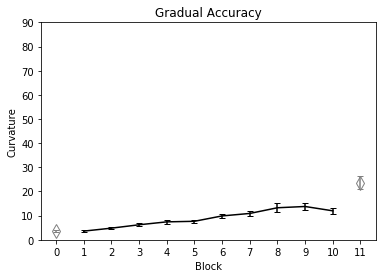

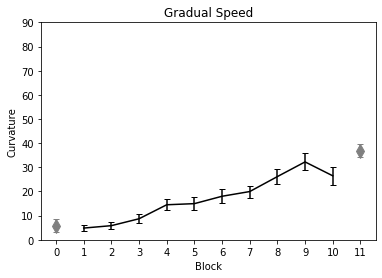

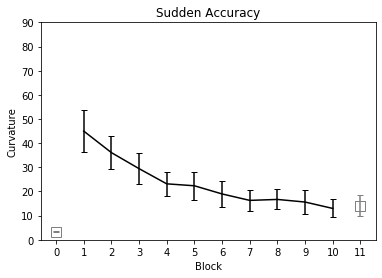

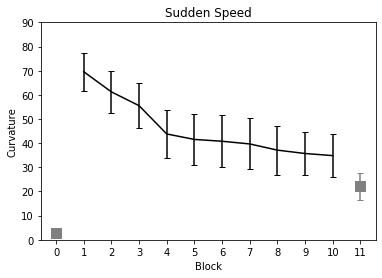

In [10]:
def plot_curvature_means(distances, path):
    #plt.rcParams[('figure.figsize')] = [8, 6]

    mean_errors = numpy.mean(distances, axis =2)
    plt.errorbar(range(1, 11), numpy.mean(numpy.nanmedian(distances, axis = 2)[3::4], axis = 0)[1:-1], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[3::4], axis = 0)[1:-1], capsize=3, color = [0, 0, 0])
    plt.errorbar(0, numpy.mean(numpy.nanmedian(distances, axis = 2)[3::4], axis = 0)[0], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[3::4], axis = 0)[0], capsize=3, fmt = 'd', fillstyle = 'none', markersize = 10, color = [0.5, 0.5, 0.5])
    plt.errorbar(11, numpy.mean(numpy.nanmedian(distances, axis = 2)[3::4], axis = 0)[11], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[3::4], axis = 0)[11], capsize=3, fmt = 'd', fillstyle = 'none', markersize = 10, color = [0.5, 0.5, 0.5])
    #plt.text(x=5, y = 80, s = '14 Participants')
    plt.ylabel('Curvature')
    plt.xlabel('Block')
    plt.title('Gradual Accuracy')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])

    #y_lim_max = numpy.max((mean_errors)) + 5
    y_lim_max = 90
    plt.ylim((0, y_lim_max))
#    print(max(np.mean(quantiles[3::4][:, :, 3], axis = 0)[1:-1]) + 0.7)
    #plt.tight_layout()
    #plt.savefig(path+'learning_GA.png', dpi = 600)
    plt.show()

    plt.errorbar(range(1, 11), numpy.mean(numpy.nanmedian(distances, axis = 2)[2::4], axis = 0)[1:-1], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[2::4], axis = 0)[1:-1], capsize=3, color = [0, 0, 0])
    plt.errorbar(0, numpy.median(numpy.nanmean(distances, axis = 2)[2::4], axis = 0)[0], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[2::4], axis = 0)[0], capsize=3, fmt = 'd', fillstyle = 'full', markersize = 10, color = [0.5, 0.5, 0.5])
    plt.errorbar(11, numpy.median(numpy.nanmean(distances, axis = 2)[2::4], axis = 0)[11], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[2::4], axis = 0)[11], capsize=3, fmt = 'd', fillstyle = 'full', markersize = 10, color = [0.5, 0.5, 0.5])
    #plt.text(x=5, y = 80, s = '15 Participants')
    plt.ylabel('Curvature')
    plt.xlabel('Block')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.title('Gradual Speed')
    plt.ylim(0, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_GS.png', dpi = 600)
    plt.show()
    #y_lim_max = 2200

    plt.errorbar(range(1, 11), numpy.mean(numpy.nanmedian(distances, axis = 2)[1::4], axis = 0)[1:-1], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[1::4], axis = 0)[1:-1], capsize=3, color = [0, 0, 0])
    plt.errorbar(0, numpy.mean(numpy.nanmedian(distances, axis = 2)[1::4], axis = 0)[0], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[1::4], axis = 0)[0], capsize=3, fmt = 's', fillstyle = 'none', markersize = 10, color = [0.5, 0.5, 0.5])
    plt.errorbar(11, numpy.mean(numpy.nanmedian(distances, axis = 2)[1::4], axis = 0)[11], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[1::4], axis = 0)[11], capsize=3, fmt = 's', fillstyle = 'none', markersize = 10, color = [0.5, 0.5, 0.5])
    #plt.text(x=5, y = 80, s = '15 Participants')
    plt.ylabel('Curvature')
    plt.xlabel('Block')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.title('Sudden Accuracy')
    #y_lim_max = 10000

    plt.ylim(0, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_SA.png', dpi = 600)
    plt.show()

    plt.errorbar(range(1, 11), numpy.mean(numpy.nanmedian(distances, axis = 2)[4::4], axis = 0)[1:-1], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[4::4], axis = 0)[1:-1], capsize=3, color = [0, 0, 0])
    plt.errorbar(0, numpy.mean(numpy.nanmedian(distances, axis = 2)[4::4], axis = 0)[0], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[4::4], axis = 0)[0], capsize=3, fmt = 's', fillstyle = 'full', markersize = 10, color = [0.5, 0.5, 0.5])
    plt.errorbar(11, numpy.mean(numpy.nanmedian(distances, axis = 2)[4::4], axis = 0)[11], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[4::4], axis = 0)[11], capsize=3, fmt = 's', fillstyle = 'full', markersize = 10, color = [0.5, 0.5, 0.5])
    #plt.text(x=5, y = 80, s = '14 Participants')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.ylabel('Curvature')
    plt.xlabel('Block')
    plt.title('Sudden Speed')
#    y_lim_max = 2600
    plt.ylim(0, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_SS.png', dpi = 600)
    plt.show()

plot_curvature_means(curvatures, "")


In [95]:
numpy.shape(numpy.ravel(numpy.nanmean(curvatures[0::4], axis = 0)[1:][:, :16]))

(176,)

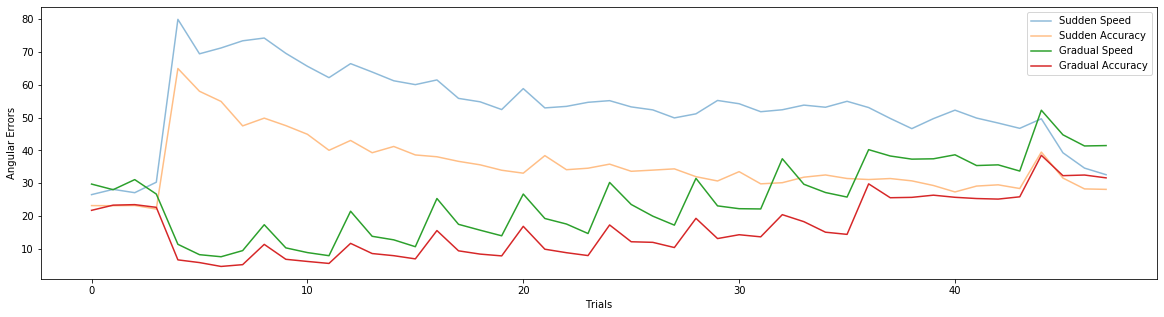

In [30]:
def plot_errors_trials(num_points, first_trial, last_trial, errors):
    plt.figure(figsize=(20, 5))
    plot_0, = plt.plot(numpy.nanmean(numpy.split(numpy.ravel(numpy.nanmean(curvatures[0::4], axis = 0)[:, first_trial:last_trial]), num_points), axis = 1), alpha = 0.5)
    plot_1, = plt.plot(numpy.nanmean(numpy.split(numpy.ravel(numpy.nanmean(curvatures[1::4], axis = 0)[:, first_trial:last_trial]), num_points), axis = 1), alpha = 0.5)
    plot_2, = plt.plot(numpy.nanmean(numpy.split(numpy.ravel(numpy.nanmean(curvatures[2::4], axis = 0)[:, first_trial:last_trial]), num_points), axis = 1))
    plot_3, = plt.plot(numpy.nanmean(numpy.split(numpy.ravel(numpy.nanmean(curvatures[3::4], axis = 0)[:, first_trial:last_trial]), num_points), axis = 1))

    plt.legend((plot_0, plot_1, plot_2, plot_3), ('Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'))
    plt.xlabel('Trials')
    plt.ylabel('Angular Errors')
plot_errors_trials(48, 0, 64, curvatures)


In [ ]:
def plot_curvature(distances, path):
    #plt.rcParams[('figure.figsize')] = [8, 6]

    mean_errors = numpy.mean(distances, axis =2)
    plt.errorbar(range(1, 11), numpy.mean(numpy.nanmean(distances, axis = 2)[3::4], axis = 0)[1:-1], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[3::4], axis = 0)[1:-1], capsize=3, color = [0, 0, 0])
    #plt.errorbar(0, numpy.mean(numpy.median(distances, axis = 2)[3::4], axis = 0)[0], yerr = stat.sem(numpy.median(distances, axis = 2)[3::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.nanmean(distances, axis = 2)[3::4], axis = 0)[11], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[3::4], axis = 0)[11], capsize=3, fmt = 'd', fillstyle = 'none', markersize = 10, color = [0.5, 0.5, 0.5])
    #plt.text(x=5, y = 80, s = '14 Participants')
    plt.ylabel('Curvature')
    plt.xlabel('Block')
    plt.title('Gradual Accuracy')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])

    #y_lim_max = numpy.max((mean_errors)) + 5
    y_lim_max = 90
    plt.ylim((0, y_lim_max))
#    print(max(np.mean(quantiles[3::4][:, :, 3], axis = 0)[1:-1]) + 0.7)
    #plt.tight_layout()
    #plt.savefig(path+'learning_GA.png', dpi = 600)
    plt.show()

    plt.errorbar(range(1, 11), numpy.mean(numpy.nanmean(distances, axis = 2)[2::4], axis = 0)[1:-1], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[2::4], axis = 0)[1:-1], capsize=3, color = [0, 0, 0])
    #plt.errorbar(0, numpy.mean(numpy.median(distances, axis = 2)[2::4], axis = 0)[0], yerr = stat.sem(numpy.median(distances, axis = 2)[2::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.nanmean(distances, axis = 2)[2::4], axis = 0)[11], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[2::4], axis = 0)[11], capsize=3, fmt = 'd', fillstyle = 'full', markersize = 10, color = [0.5, 0.5, 0.5])
    #plt.text(x=5, y = 80, s = '15 Participants')
    plt.ylabel('Curvature')
    plt.xlabel('Block')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.title('Gradual Speed')
    plt.ylim(0, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_GS.png', dpi = 600)
    plt.show()
    #y_lim_max = 2200

    plt.errorbar(range(1, 11), numpy.mean(numpy.nanmean(distances, axis = 2)[1::4], axis = 0)[1:-1], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[1::4], axis = 0)[1:-1], capsize=3, color = [0, 0, 0])
    #plt.errorbar(0, numpy.mean(numpy.mean(distances, axis = 2)[1::4], axis = 0)[0], yerr = stat.sem(numpy.mean(distances, axis = 2)[1::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.nanmean(distances, axis = 2)[1::4], axis = 0)[11], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[1::4], axis = 0)[11], capsize=3, fmt = 's', fillstyle = 'none', markersize = 10, color = [0.5, 0.5, 0.5])
    #plt.text(x=5, y = 80, s = '15 Participants')
    plt.ylabel('Curvature')
    plt.xlabel('Block')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.title('Sudden Accuracy')
    #y_lim_max = 10000

    plt.ylim(0, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_SA.png', dpi = 600)
    plt.show()

    plt.errorbar(range(1, 11), numpy.mean(numpy.nanmean(distances, axis = 2)[4::4], axis = 0)[1:-1], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[4::4], axis = 0)[1:-1], capsize=3, color = [0, 0, 0])
    #plt.errorbar(0, numpy.mean(numpy.median(distances, axis = 2)[4::4], axis = 0)[0], yerr = stat.sem(numpy.median(distances, axis = 2)[4::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.nanmean(distances, axis = 2)[4::4], axis = 0)[11], yerr = stat.sem(numpy.nanmedian(distances, axis = 2)[4::4], axis = 0)[11], capsize=3, fmt = 's', fillstyle = 'full', markersize = 10, color = [0.5, 0.5, 0.5])
    #plt.text(x=5, y = 80, s = '14 Participants')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.ylabel('Curvature')
    plt.xlabel('Block')
    plt.title('Sudden Speed')
#    y_lim_max = 2600
    plt.ylim(0, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_SS.png', dpi = 600)
    plt.show()

plot_curvature_means(curvatures, "")


In [ ]:
y = numpy.array([numpy.mean(numpy.mean(curvatures, axis = 2)[0::4], axis = 0)[11],
                 numpy.mean(numpy.mean(curvatures, axis = 2)[1::4], axis = 0)[11],
                 numpy.mean(numpy.mean(curvatures, axis = 2)[2::4], axis = 0)[11],
                 numpy.mean(numpy.mean(curvatures, axis = 2)[3::4], axis = 0)[11]])
y_sem = numpy.array([stat.sem(numpy.nanmean(curvatures, axis = 2)[0::4], axis = 0)[11],
                     stat.sem(numpy.nanmean(curvatures, axis = 2)[1::4], axis = 0)[11],
                     stat.sem(numpy.nanmean(curvatures, axis = 2)[2::4], axis = 0)[11],
                     stat.sem(numpy.nanmean(curvatures, axis = 2)[3::4], axis = 0)[11]])

plt.bar(0, y[0], yerr = y_sem[0])
plt.bar(1, y[1], yerr = y_sem[1])
plt.bar(2, y[2], yerr = y_sem[2])
plt.bar(3, y[3], yerr = y_sem[3])


#plt.xticks(['Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'], rotation = 'vertical')

[[ 9.57193488 18.27314411 21.0092538  33.30562627]
 [25.7075039  35.77524456 30.68035599 42.87246533]]
[17.63971939 27.02419434 25.84480489 38.0890458 ]
[8.067784506469604, -8.067784506469604]
[17.63971939 27.02419434 25.84480489 38.0890458 ]


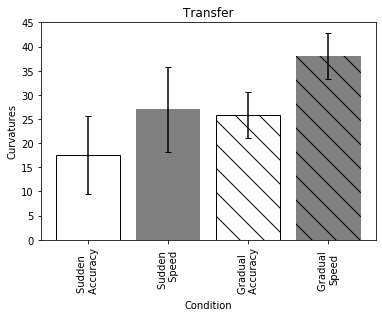

In [23]:
#numpy.mean(numpy.mean(error_sum[1::4], axis = 2), axis = 0)
#stat.sem(numpy.mean(error_sum[1::4], axis = 2), axis = 0)
def plot_curvature_means_transfer(distances, text):
#    quantiles = get_quantile(total_times)
    xpos = [0, 1, 2, 3, 4]
    y = numpy.array([numpy.mean(numpy.nanmean(distances[1::4], axis = 2), axis = 0)[11],# - numpy.mean(numpy.median(distances[1::4], axis = 2), axis = 0)[10],
                  numpy.mean(numpy.nanmean(distances[0::4], axis = 2), axis = 0)[11], #- numpy.mean(numpy.median(distances[4::4], axis = 2), axis = 0)[10],
                  numpy.mean(numpy.nanmean(distances[3::4], axis = 2), axis = 0)[11], #- numpy.mean(numpy.median(distances[3::4], axis = 2), axis = 0)[10],
                  numpy.mean(numpy.nanmean(distances[2::4], axis = 2), axis = 0)[11]] #- numpy.mean(numpy.median(distances[2::4], axis = 2), axis = 0)[10]] 
                  )
    
    y_sem = numpy.array([stat.sem(numpy.nanmean(distances[1::4], axis = 2), axis = 0)[11], 
                    stat.sem(numpy.nanmean(distances[0::4], axis = 2), axis = 0)[11],
                    stat.sem(numpy.nanmean(distances[3::4], axis = 2), axis = 0)[11],
                    stat.sem(numpy.nanmean(distances[2::4], axis = 2), axis = 0)[11]])
    print(numpy.array(stat.norm.interval(0.95, loc = y, scale = y_sem)))
    print(y)
    #x_CI = x - np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[0, :], np.array(stat.norm.interval(0.95, loc = x, scale = x_err))[1, :] - x
    y_CI = y - numpy.array(stat.norm.interval(0.95, loc = y, scale = y_sem))#[0, :], numpy.array(stat.norm.interval(0.95, loc = y, scale = y_sem))[1, :]
    #print (y_CI)
    #print (y_sem[0])
    #y_sem = numpy.array([0, 0, 0, 0])
    print([y_CI[0][0], y_CI[1][0]])
    plt.bar(0, y[0], yerr = y_CI[0][0], capsize = 3, fill = False)
    plt.bar(1, y[1], yerr = y_CI[0][1], capsize = 3, color = [0.5, 0.5, 0.5])
    plt.bar(2, y[2], yerr = y_CI[0][2], capsize = 3, hatch = '\\', fill = False)
    plt.bar(3, y[3], yerr = y_CI[0][3], capsize = 3, hatch = '\\', color = [0.5, 0.5, 0.5])

#    handles = plt.bar(range(4), y, yerr = y_sem, capsize = 3, color = ['Blue', 'Green', 'Blue', 'Green'], alpha = [1, 0.5, 0.5, 1])
    plt.xticks([0, 1, 2, 3], ['Sudden \n Accuracy', 'Sudden \n Speed', 'Gradual \n Accuracy', 'Gradual \nSpeed'], rotation = 'vertical')
    plt.ylabel('Curvatures')
    plt.xlabel('Condition')
    #plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
    plt.title(text)
    plt.ylim(0, 45)
    print (y)
#numpy.shape(numpy.mean(error_sum[1::4], axis = 0))
plot_curvature_means_transfer(curvatures, 'Transfer')

In [ ]:
curvatures[1::4]

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
ols()

In [ ]:
stat.f_oneway(numpy.mean(curvatures[0::4, :, :], axis = 2)[:, 11], numpy.mean(curvatures[1::4, :, :], axis = 2)[:, 11], numpy.mean(curvatures[2::4, :, :], axis = 2)[:, 11], numpy.mean(curvatures[3::4, :, :], axis = 2)[:, 11])

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({"Emphasis": numpy.tile(["Speed", "Accuracy"], 30),
                   "Rotation": numpy.tile(["Sudden", "Sudden", "Gradual", "Gradual"], 15),
                   "Curvature": numpy.nanmean(curvatures[:, :, :], axis = 2)[:, 11]})

In [ ]:
d_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['Sudden_Speed', 'Sudden_Accuracy', 'Gradual_Speed', 'Gradual_Accuracy'])

In [ ]:
model = ols('Curvature ~ C(Emphasis)*C(Rotation)', data=df).fit()

In [ ]:
aov_table = sm.stats.anova_lm(model)
print(aov_table)

In [ ]:
model.summary()

In [ ]:
aov_table

In [ ]:
df.boxplot('Curvature', by='Rotation', figsize=(8, 6))

In [ ]:
import statsmodels.formula.api as smf
md = smf.mixedlm('Curvature ~ C(Emphasis)*C(Rotation)', data=df, groups = df['Emphasis'])
mdf = md.fit()


In [ ]:
mdf.summary()

In [ ]:
model_lm = sm.OLS(numpy.ravel(curvatures[0, 11, :]),numpy.array(range(64))).fit()

In [ ]:
model_lm.summary()

In [ ]:
plt.plot(range(64), numpy.mean(curvatures[3::4, :, :], axis = 0)[10])


In [36]:
def calc_curvature_raw(data, block, trial, percentage_trajectory):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
    targetx, targety = trajx[-1], trajy[-1]
    partial_trajx, partial_trajy = get_partial_traj(data, block, trial, percentage_trajectory)
    angles = list()
    for i in range(len(partial_trajx[:-1])):
        #print (trajx[i], trajy[i])
        angles.append(calc_angle(numpy.array([partial_trajx[i], partial_trajy[i]]), numpy.array([partial_trajx[i+1], partial_trajy[i+1]]), numpy.array([trajx[-1], trajy[-1]])))
    return angles

In [37]:
raw_curvatures = numpy.zeros((60, 12, 64), dtype = object)
for data in range(60):
    for block in range(12):
        for trial in range(64):
            raw_curvatures[data][block][trial] = calc_curvature_raw(data+1000, block, trial, 1)
    if data%10 == 0:
        print (data)

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


0
10
20
30
40
50


In [16]:
def plot_distributions(perc_trajectory):
    raw_curvatures = numpy.zeros((60, 11, 64), dtype = object)
    for data in range(60):
        for block in range(11):
            for trial in range(64):
                raw_curvatures[data][block][trial] = calc_curvature_raw(data+1000, block, trial, perc_trajectory)
        if data%10 == 0:
            print (data)
    
    fig, ax = plt.subplots(2, 2, sharex = True, sharey = True)
    ax[0, 0].hist(numpy.hstack(numpy.ravel(raw_curvatures[0::4])))
    ax[0, 0].set_title('Sudden Speed')
    ax[0, 1].hist(numpy.hstack(numpy.ravel(raw_curvatures[1::4])))
    ax[0, 1].set_title('Sudden Accuracy')
    ax[1, 0].hist(numpy.hstack(numpy.ravel(raw_curvatures[2::4])))
    ax[1, 0].set_title('Gradual Speed')
    ax[1, 1].hist(numpy.hstack(numpy.ravel(raw_curvatures[3::4])))
    ax[1, 1].set_title('Gradual Accuracy')
    title_text = str(perc_trajectory*100) + "% of the trajectory"
    fig.suptitle(title_text)
    #plt.grid(False)
    #plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xlabel('Curvature Errors in degrees')
    plt.ylabel('Frequencies')

C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


0


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """


10
20
30
40
50


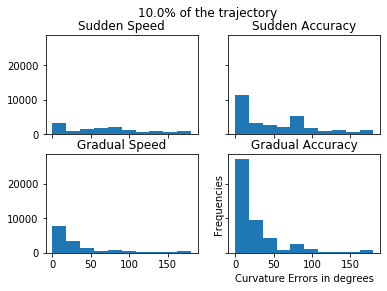

In [17]:
plot_distributions(0.1)

In [277]:
##### numpy.quantile(range(len(raw_curvatures[1][1][1])), [0.1, 0.3, 0.5, 0.7, 0.9])
raw_curvatures[1][1][1][120]
numpy.take(raw_curvatures[1][1][1], [24.1, 72.3, 120.5])

array([105.19240901,  52.12501635,  63.66231183])

## Dist Analyses with Medians

In [39]:
quantile_curvatures = numpy.zeros((60, 12, 64, 5))
for data in range(60):
    for block in range(12):
        for trial in range(64):
            try:
                quantile_index = numpy.quantile(range(len(raw_curvatures[data][block][trial])), [0.1, 0.3, 0.5, 0.7, 0.9]).tolist()
                quantile_curvatures[data][block][trial] = numpy.take(raw_curvatures[data][block][trial], quantile_index)
            except:
                print('Some error')

Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error

## Dist Analysis with Means

In [40]:
quantile_curvatures_means = numpy.zeros((60, 12, 64, 5))
for data in range(60):
    for block in range(12):
        for trial in range(64):
            try:
                quantile_index = numpy.quantile(range(len(raw_curvatures[data][block][trial])), [0.2, 0.4, 0.6, 0.8, 1]).tolist()
                quantile_curvatures_means[data][block][trial] = numpy.array([numpy.nanmean(raw_curvatures[data][block][trial][0:int(quantile_index[0])]), 
                                                                             numpy.nanmean(raw_curvatures[data][block][trial][int(quantile_index[0]):int(quantile_index[1])]), 
                                                                             numpy.nanmean(raw_curvatures[data][block][trial][int(quantile_index[1]):int(quantile_index[2])]),
                                                                             numpy.nanmean(raw_curvatures[data][block][trial][int(quantile_index[2]):int(quantile_index[3])]), 
                                                                             numpy.nanmean(raw_curvatures[data][block][trial][int(quantile_index[3]):int(quantile_index[4])])])
            except:
                print('Some Error')


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


Some Error


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error
Some Error

In [41]:
quantile_curvatures_means[5][2][:32]

array([[  7.25723129,   7.89879504,  11.78018992,   8.0269385 ,
          6.72183201],
       [ 11.39347434,   9.48449036,   5.33067629,   3.35498624,
          2.58665775],
       [171.87102229, 160.39648972,          nan,  60.09339125,
          7.59652155],
       [  3.51105922,   4.73921822,   5.16257206,   4.4695911 ,
          4.25939148],
       [ 83.38398315,  80.26493666,  81.27143666,  72.10887336,
         39.00746293],
       [  6.02106844,   3.37856236,   2.68908076,   5.12081416,
          3.98464743],
       [  6.52725673,   5.98363939,   8.93214358,   5.48378961,
          5.66849726],
       [  7.03126216,   5.19231654,   3.78409817,   5.26224562,
          5.37910076],
       [  4.64249729,   4.53943104,  10.25147557,  14.99842387,
         30.41477352],
       [  8.65771559,  24.71699516,  74.26949859, 128.78516246,
        153.34023115],
       [ 22.85403047,  23.14077397,  31.02892057,  61.9194449 ,
         81.36823418],
       [  8.62443343,  11.51655657,  19.790

In [42]:
def plot_curv_dist(block, quantile_curvatures, fist_traj, last_traj):
    y = numpy.array([numpy.nanmean(numpy.nanmean(quantile_curvatures[0::4, :, fist_traj:last_traj], axis = 2), axis = 0)[block],
                     numpy.nanmean(numpy.nanmean(quantile_curvatures[1::4, :, fist_traj:last_traj], axis = 2), axis = 0)[block],
                     numpy.nanmean(numpy.nanmean(quantile_curvatures[2::4, :, fist_traj:last_traj], axis = 2), axis = 0)[block],
                     numpy.nanmean(numpy.nanmean(quantile_curvatures[3::4, :, fist_traj:last_traj], axis = 2), axis = 0)[block]])
    y_err = numpy.array([stat.sem(numpy.nanmean(quantile_curvatures[0::4, :, fist_traj:last_traj], axis = 2), axis = 0)[block],
                       stat.sem(numpy.nanmean(quantile_curvatures[1::4, :, fist_traj:last_traj], axis = 2), axis = 0)[block],
                       stat.sem(numpy.nanmean(quantile_curvatures[2::4, :, fist_traj:last_traj], axis = 2), axis = 0)[block],
                       stat.sem(numpy.nanmean(quantile_curvatures[3::4, :, fist_traj:last_traj], axis = 2), axis = 0)[block]])
    print (y[1])
    plot_0 = plt.errorbar(range(5), y[0], y_err[0], capsize = 3)
    plot_1 = plt.errorbar(range(5), y[1], y_err[1], capsize = 3)
    plot_2 = plt.errorbar(range(5), y[2], y_err[2], capsize = 3)
    plot_3 = plt.errorbar(range(5), y[3], y_err[3], capsize = 3)

    plt.legend((plot_0, plot_1, plot_2, plot_3), ('Sudden Speed', 'Sudden Accuracy', 'Gradual Accuracy', 'Gradual Speed'))
    title = 'Block: ' + str(block)
    plt.title(title)
    plt.xlabel('Quantile points')
    plt.ylabel('Angular errror')

[26.12535719 25.3884783  26.2745213  24.16556444 18.02243538]


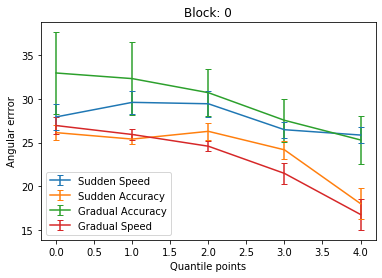

In [47]:
plot_curv_dist(0, quantile_curvatures, 0, 32)

In [ ]:
## plot_curv_dist(11, quantile_curvatures)

In [171]:
numpy.quantile(range(len(raw_curvatures[data][block][trial])), [0.1, 0.3, 0.5, 0.7, 0.9])

array([ 3.,  9., 15., 21., 27.])

In [40]:
numpy.nanmean(numpy.nanmean(quantile_curvatures[0::4, :, :16], axis = 2), axis = 0)[block]

array([38.31014677, 51.05531969, 59.38756186, 50.08345444, 45.54493824])

(15, 12, 16, 5)

Value = (1 - alpha)*(1/error) + (alpha)*(1/Total time)